In [1]:
import torch
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from models.hybrid_model import HybridModel

In [2]:
dataset_df = pd.read_parquet('data\\final_dataset.parquet')
dataset_df['anchor_age'] = dataset_df['anchor_age'].astype(float)
dataset_df['gender_numeric'] = dataset_df['gender_numeric'].astype(float)

unique_stay_ids = dataset_df['stay_id'].unique()
train_ids, test_ids = train_test_split(unique_stay_ids, test_size=0.2, random_state=42)
train_ids, val_ids = train_test_split(train_ids, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

dataset_df['split'] = 'test'
dataset_df.loc[dataset_df['stay_id'].isin(train_ids), 'split'] = 'train'
dataset_df.loc[dataset_df['stay_id'].isin(val_ids), 'split'] = 'val'

print(f"Train length: {len(dataset_df[dataset_df['split'] == 'train'])}")
print(f"Val length: {len(dataset_df[dataset_df['split'] == 'val'])}")
print(f"Test length: {len(dataset_df[dataset_df['split'] == 'test'])}")

Train length: 993179
Val length: 323568
Test length: 329155


In [3]:
demographic_features = ['anchor_age', 'gender_numeric']
static_features = [col for col in dataset_df.columns if col.startswith('item_') and '_t' not in col]
static_features = demographic_features + static_features
sequential_features = [col for col in dataset_df.columns if col.startswith('item_') and '_t' in col]

print(f"Static features length: {len(static_features)}")
print(f"Sequential features length: {len(sequential_features)}")

Static features length: 50
Sequential features length: 27


In [4]:
def balance_training_set(df_train, target, task):
    if task == "classification":
        # Binary case
        minority = df_train[df_train[target] == 1]
        majority = df_train[df_train[target] == 0].sample(n=len(minority), random_state=42)
        df_train = pd.concat([minority, majority]).sample(frac=1, random_state=42)
    elif task == "multiclass":
        # Multiclass case: balance across all classes
        counts = df_train[target].value_counts()
        min_count = counts.min()
        df_train = pd.concat([
            df_train[df_train[target] == cls].sample(min_count, random_state=42)
            for cls in counts.index
        ]).sample(frac=1, random_state=42)
    return df_train

def prepare_inputs(df_sub):
    X_static = scaler_static.transform(df_sub[static_features])
    X_seq = scaler_seq.transform(df_sub[sequential_features])
    time_steps = sorted(set(int(col.split('_t')[1]) for col in sequential_features))
    features = sorted(set(col.split('_t')[0] for col in sequential_features))
    X_seq = X_seq.reshape((X_seq.shape[0], len(time_steps), len(features)))
    y = df_sub[target].values
    if task == "classification":
        y = (y >= 1).astype(int)
    elif task == "multiclass":
        y = y.astype(int)
    return torch.tensor(X_static).float(), torch.tensor(X_seq).float(), torch.tensor(y)

In [5]:
task = "classification"
target = "gcs_deterioration_binary"
balance_data = True

# === Split data ===
df_train = dataset_df[dataset_df["split"] == "train"]
df_val = dataset_df[dataset_df["split"] == "val"]
df_test = dataset_df[dataset_df["split"] == "test"]

if balance_data and task in ["classification", "multiclass"]:
    df_train = balance_training_set(df_train, target, task)

# === Scale static & sequential features ===
scaler_static = StandardScaler()
scaler_seq = StandardScaler()
scaler_static.fit(df_train[static_features])
scaler_seq.fit(df_train[sequential_features])

X_static_train, X_seq_train, y_train = prepare_inputs(df_train)
X_static_val, X_seq_val, y_val = prepare_inputs(df_val)
X_static_test, X_seq_test, y_test = prepare_inputs(df_test)

print("Train labels:", np.unique(y_train.numpy(), return_counts=True))
print("Val labels:", np.unique(y_val.numpy(), return_counts=True))
print("Test labels:", np.unique(y_test.numpy(), return_counts=True))

Train labels: (array([0, 1]), array([31579, 31579]))
Val labels: (array([0, 1]), array([313275,  10293]))
Test labels: (array([0, 1]), array([318534,  10621]))


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = HybridModel(
    static_dim=X_static_test.shape[1],
    seq_feature_dim=X_seq_test.shape[2],
    task="classification",
    lstm_hidden=64,
    static_hidden=[64, 32],
    dropout=0.2
)

model.load_state_dict(torch.load("results/exp_gcs_deterioration_binary/best_model.pt"))
model = model.to(device)
model.eval()

HybridModel(
  (lstm): LSTM(9, 64, batch_first=True)
  (seq_fc): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (static_fc): Sequential(
    (0): Linear(in_features=50, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
  )
  (final): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [7]:
n_samples = 300
indices = np.random.choice(len(X_static_test), size=n_samples, replace=False)

X_static_sample = X_static_test[indices]
X_seq_sample = X_seq_test[indices]

X_static_np = X_static_sample.cpu().numpy()
X_seq_np = X_seq_sample.cpu().numpy()

X_seq_flat_np = X_seq_np.reshape(X_seq_np.shape[0], -1)
X_combined_np = np.concatenate([X_static_np, X_seq_flat_np], axis=1)

print(f"X_static_sample shape: {X_static_np.shape}")
print(f"X_seq_sample shape: {X_seq_np.shape}")
print(f"X_combined shape: {X_combined_np.shape}")

X_static_sample shape: (300, 50)
X_seq_sample shape: (300, 3, 9)
X_combined shape: (300, 77)


In [8]:
def predict_fn(x_np):
    x_tensor = torch.tensor(x_np, dtype=torch.float32, device=device)
    static = x_tensor[:, :X_static_np.shape[1]]
    seq = x_tensor[:, X_static_np.shape[1]:]
    seq = seq.view(-1, X_seq_np.shape[1], X_seq_np.shape[2])
    with torch.no_grad():
        preds = model(static, seq)
    if isinstance(preds, tuple):
        preds = preds[0]
    return preds.cpu().numpy()

In [9]:
explainer = shap.KernelExplainer(predict_fn, X_combined_np[:50])

In [10]:
shap_values = explainer.shap_values(X_combined_np)

  0%|          | 0/300 [00:00<?, ?it/s]

In [11]:
item_label_lookup = pd.read_csv('data\\d_items.csv').set_index('itemid')['label']
labitem_label_lookup = pd.read_csv('data\\d_labitems.csv').set_index('itemid')['label']

nice_seq_features = []
for feat in sequential_features:
    base_feat, time_offset = feat.split("_t")
    nice_seq_features.append(f"{base_feat} t-{time_offset}h")

def format_feature_name(feature_name):
    if 'item_' in feature_name:
        itemid_str = feature_name.split()[0].replace('item_', '')
        t_str = feature_name.split()[1] if 't-' in feature_name else ''
        label = item_label_lookup[int(itemid_str)] if itemid_str[0] == '2' else labitem_label_lookup[int(itemid_str)]
        return label + ' ' + t_str
    if feature_name == 'anchor_age':
        return 'Age'
    if feature_name == 'gender_numeric':
        return 'Gender'

nice_feature_names = static_features + nice_seq_features
nice_feature_names = [format_feature_name(f) for f in nice_feature_names]
nice_feature_names

['Age',
 'Gender',
 'GCS - Eye Opening ',
 'Temperature Fahrenheit ',
 'GCS - Verbal Response ',
 'GCS - Motor Response ',
 'Braden Sensory Perception ',
 'Braden Moisture ',
 'Braden Activity ',
 'Braden Mobility ',
 'Braden Nutrition ',
 'Braden Friction/Shear ',
 'Richmond-RAS Scale ',
 'Strength L Arm ',
 'Strength L Leg ',
 'Strength R Leg ',
 'Strength R Arm ',
 'Activity / Mobility (JH-HLM) ',
 'Base Excess ',
 'Calculated Total CO2 ',
 'pCO2 ',
 'pH ',
 'pO2 ',
 'Anion Gap ',
 'Bicarbonate ',
 'Calcium, Total ',
 'Chloride ',
 'Creatinine ',
 'Glucose ',
 'H ',
 'I ',
 'Magnesium ',
 'Phosphate ',
 'Potassium ',
 'Sodium ',
 'Urea Nitrogen ',
 'Hematocrit ',
 'Hemoglobin ',
 'INR(PT) ',
 'MCH ',
 'MCHC ',
 'MCV ',
 'Platelet Count ',
 'PT ',
 'PTT ',
 'RDW ',
 'Red Blood Cells ',
 'White Blood Cells ',
 'L ',
 'RDW-SD ',
 'Heart Rate t-2h',
 'Heart Rate t-3h',
 'Heart Rate t-4h',
 'Arterial Blood Pressure systolic t-2h',
 'Arterial Blood Pressure systolic t-3h',
 'Arterial Bloo

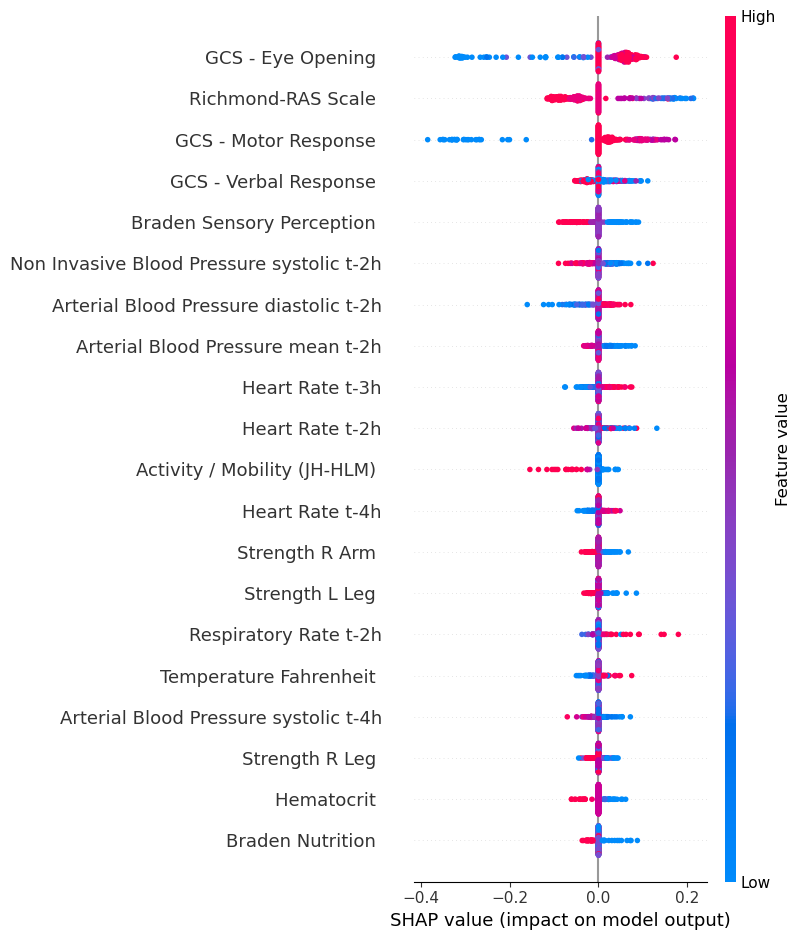

In [12]:
shap.summary_plot(shap_values, X_combined_np, nice_feature_names)

In [13]:
mean_abs_shap = np.abs(shap_values).mean(axis=0)  # Shape: (n_features,)

importance_df = pd.DataFrame({
    "Feature": nice_feature_names,
    "MeanAbsSHAP": mean_abs_shap
})

importance_df = importance_df.sort_values("MeanAbsSHAP", ascending=False).reset_index(drop=True)
importance_df

,Feature,MeanAbsSHAP
0,GCS - Eye Opening,0.069908
1,Richmond-RAS Scale,0.066244
2,GCS - Motor Response,0.058517
3,GCS - Verbal Response,0.022517
4,Braden Sensory Perception,0.017190
...,...,...
72,Arterial Blood Pressure diastolic t-3h,0.000000
73,Non Invasive Blood Pressure diastolic t-3h,0.000000
74,Respiratory Rate t-4h,0.000000
75,O2 saturation pulseoxymetry t-2h,0.000000


In [16]:
print(importance_df.head(20))

                                      Feature  MeanAbsSHAP
0                          GCS - Eye Opening      0.069908
1                         Richmond-RAS Scale      0.066244
2                       GCS - Motor Response      0.058517
3                      GCS - Verbal Response      0.022517
4                  Braden Sensory Perception      0.017190
5   Non Invasive Blood Pressure systolic t-2h     0.016616
6      Arterial Blood Pressure diastolic t-2h     0.014347
7           Arterial Blood Pressure mean t-2h     0.009488
8                             Heart Rate t-3h     0.007819
9                             Heart Rate t-2h     0.007803
10              Activity / Mobility (JH-HLM)      0.005906
11                            Heart Rate t-4h     0.005565
12                            Strength R Arm      0.005486
13                            Strength L Leg      0.005080
14                      Respiratory Rate t-2h     0.004870
15                    Temperature Fahrenheit      0.0048